<a href="#1-PCA" style="margin-left: 0px;">1 PCA</a>  
<a href="#2-SVD" style="margin-left: 0px;">2 SVD</a>    
<a href="#3-TSNE" style="margin-left: 0px;">3 TSNE</a>   
<a href="#4-UMAP" style="margin-left: 0px;">4 UMAP</a>    
<a href="#5-LocallyLinearEmbedding" style="margin-left: 0px;">5 Locally Linear Embedding</a>   
<a href="#6-The-quality-of-dimensionality-reduction-will-be-evaluated-using-our-own-metric" style="margin-left: 0px;">6 The quality of dimensionality reduction will be evaluated using our own metric</a>   

In [1]:
import pandas as pd
import numpy as np

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import TSNE, LocallyLinearEmbedding
import umap
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import cdist
from tensorflow.keras.datasets import mnist

#### Что входит в MNIST?  

- 60,000 изображений для обучения (train).  
- 10,000 изображений для тестирования (test).  
- Каждое изображение – это чёрно-белая картинка 28x28 пикселей с цифрой (от 0 до 9).  
- Каждый пиксель имеет значение от 0 (чёрный) до 255 (белый).  

In [2]:
# Загружаем данные
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Объединяем тренировочные и тестовые данные
X_all = np.vstack([X_train, X_test])  # Все изображения (70000, 28, 28)
y_all = np.hstack([y_train, y_test])  # Все метки (70000,)

print(f"Форма данных: {X_all.shape}, метки: {y_all.shape}")

Форма данных: (70000, 28, 28), метки: (70000,)


In [3]:
del X_train, y_train, X_test, y_test

In [4]:
X_all_flat = X_all.reshape(X_all.shape[0], -1)  # (70000, 784)

In [5]:
X_all_flat = X_all_flat[:10000]  # (10000, 784)
y_all = y_all[:10000]

In [6]:
# Получаем уникальные значения и их количество
unique_values, counts = np.unique(y_all, return_counts=True)

# Выводим результат
for value, count in zip(unique_values, counts):
    print(f"Значение {value} встречается {count} раз(а)")

Значение 0 встречается 1001 раз(а)
Значение 1 встречается 1127 раз(а)
Значение 2 встречается 991 раз(а)
Значение 3 встречается 1032 раз(а)
Значение 4 встречается 980 раз(а)
Значение 5 встречается 863 раз(а)
Значение 6 встречается 1014 раз(а)
Значение 7 встречается 1070 раз(а)
Значение 8 встречается 944 раз(а)
Значение 9 встречается 978 раз(а)


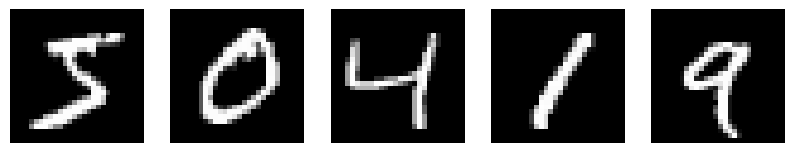

In [7]:
# пример циферек

fig, axes = plt.subplots(1, 5, figsize=(10, 2))
for i, ax in enumerate(axes):
    ax.imshow(X_all[i], cmap="gray")
    ax.axis("off")
plt.show()

### 1 PCA

PCA использует ковариационную матрицу, что предполагает, что данные центрированы (среднее по каждому признаку равно нулю).

**PCA (Principal Component Analysis)**:
  - Метод анализа данных, который используется для уменьшения размерности.
  - Основная цель — найти новые переменные (главные компоненты), которые объясняют как можно больше вариации данных.
  - Главные вектора(компоненты) ортогональны друг другу и упорядочены по убыванию собственных значений.

- Сначала вычисляется ковариационная матрица:  
$cov(x,y) = \frac{\sum\limits_{i=1}^{n}(x_{i}-\bar{x})(y_{i}-\bar{y})}{N}$  

1) Рассчитываем матрицу ковариации (отражают **линейную зависимость** между признаками)    

$
A = \begin{bmatrix}
    C_{aa} & C_{ab} & C_{ac} \\
    C_{ab} & C_{bb} & C_{bc} \\
    C_{ac} & C_{bc} & C_{cc} \\
\end{bmatrix}
$

**Пример:**    
Пусть у нас матрица размерности 10 строк на 5 столбцов,  
У нас 5 размерностей (5 столбцов), тогда ковариационная матрица будет 5 на 5

Как считается 1 элемент **$C_{aa}$** ?   
Мы берем первые 2 столбца, допустим 

1-ый столбец = [170, 165, 180, 175, 160, 185, 172, 168, 178, 182], среднее $\bar{X}_1 = 173.5$  
2-ой столбец = [70, 65, 80, 75, 60, 85, 72, 68, 78, 83], среднее $\bar{X}_2 = 73.6$  

**$C_{aa}$** = (170-173.5)*(70-73.6) + (165-173.5)*(65-73.6) + ... + (180-173.5)*(80-73.6) = 577.0

2) Рассчитываем собственные значения и собственные вектора матрицы  
3) Сортируем собственные вектора по собественным значениям в убывающем порядке  
4) Выбираем k собственных вектором, образуется новое k-мерное пространство  
5) Конвертируем исходные точки из n-мерного в k-мерное пространство  


$Ф_{A}(λ) = |A-λE| = 0$ (например: $-λ^{3}+λ^{2}+2λ=0$, (A - матрица ковариаций в нашем случае)  
$AV_{i} = λ_{i}V{i}$ ($V_{i}$≠0), $V_{i}$ - собственный вектор,    
 
  
V - матрица базисных векторов  
$X^{new} = V_{усеченная}X^{old}$    
$V_{усеченная}$ - берем столько размерностей, сколько нужно в задаче  

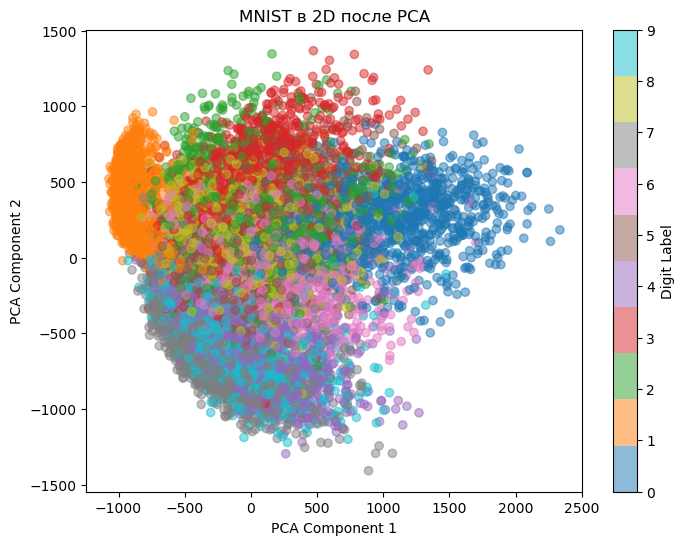

CPU times: total: 1.7 s
Wall time: 870 ms


In [8]:
%%time

# Применяем PCA для уменьшения размерности c 784 до 2
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_all_flat)  # Преобразуем 784 -> 2

# Визуализация результата
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_all, cmap="tab10", alpha=0.5)
plt.colorbar(scatter, label="Digit Label")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("MNIST в 2D после PCA")
plt.show()

### 2 SVD

### 2.1 Кратко SVD

Truncated SVD работает напрямую с матрицей данных (не требует центровки).

**1 SVD разложит эту матрицу на:**  
$$
A = U \Sigma V^T
$$

- $U$ содержит информацию о пользователях.
- $\Sigma$ указывает на "вес" каждого латентного фактора.
- $V^T$ содержит информацию о фильмах.

**2 Понижение размерности**
$$
X_k = U_k \Sigma_k
$$

### 2.2 Различия PCA и SVD

PCA использует матрицу ковариаций данных для нахождения собственных векторов и собственных значений. В PCA мы проходим по матрице ковариаций $C = \frac{1}{n} X^T X$, где $X$ — это матрица данных. Собственные векторы этой матрицы дают главные компоненты, а их собственные значения — это величины, которые показывают, насколько значимы эти компоненты для описания данных.

SVD же раскладывает матрицу данных $A$ как $A = U \Sigma V^T$, где матрица $U$ содержит левые сингулярные векторы (ассоциированные с данными), $\Sigma$ — это диагональная матрица сингулярных значений, а $V$ — правые сингулярные векторы. SVD не использует матрицу ковариаций, как PCA, и может применяться к любым матрицам, включая прямоугольные, а не только квадратные.

- SVD разлагает матрицу $A$ следующим образом:
$A = U \Sigma V^T$,
где:

### Как находятся сингулярные значения и векторы?

#### Сингулярные значения ($\sigma_i$):

Сингулярные значения — это квадратные корни собственных значений матриц $A^T A$ или $A A^T$:

$$
\sigma_i = \sqrt{\lambda_i}, \quad \text{где } \lambda_i \text{ — собственное значение } A^T A \text{ или } A A^T.
$$

Собственные значения находятся из характеристического уравнения:

$$
\det(A^T A - \lambda I) = 0
$$

---

#### Правые сингулярные векторы ($V$):

Правые сингулярные векторы — это собственные векторы матрицы $A^T A$:

$$
(A^T A) v_i = \lambda_i v_i
$$

Столбцы матрицы $V$ — это нормированные собственные векторы $v_i$:

$$
V = [v_1, v_2, \dots, v_n]
$$

---

#### Левые сингулярные векторы ($U$):

Левые сингулярные векторы — это собственные векторы матрицы $A A^T$:

$$
(A A^T) u_i = \lambda_i u_i
$$

Либо их можно вычислить через правые сингулярные векторы и сингулярные значения:

$$
A v_i = \sigma_i u_i
$$

где $v_i$ — правый сингулярный вектор, $\sigma_i$ — соответствующее сингулярное значение, а $u_i$ — левый сингулярный вектор.


### 2.3 SVD Пример разложения для матрицы 2×2

#### 🔹 Шаг 1: Находим правые сингулярные векторы $V$

Решаем задачу на собственные значения для $A^T A$:

Вычисляем $A^T A$:

$$
A^T A = \begin{bmatrix} 
1 & 3 \\ 
2 & 4 
\end{bmatrix}^T
\begin{bmatrix} 
1 & 3 \\ 
2 & 4 
\end{bmatrix}
= \begin{bmatrix} 
5 & 11 \\ 
11 & 25 
\end{bmatrix}
$$

(Заметим, что в вашем примере была небольшая ошибка в расчете $A^T A$. Правильная матрица — $\begin{bmatrix} 5 & 11 \\ 11 & 25 \end{bmatrix}$.)

Находим собственные значения $\lambda$:

$$
\det(A^T A - \lambda I) = \det\begin{bmatrix} 
5-\lambda & 11 \\ 
11 & 25-\lambda 
\end{bmatrix} = (5-\lambda)(25-\lambda) - 121 = \lambda^2 - 30\lambda + 4 = 0
$$

Корни уравнения:

$$
\lambda_1 \approx 29.87, \quad \lambda_2 \approx 0.13
$$

Находим собственные векторы $v_i$ для каждого $\lambda_i$:

Для $\lambda_1 \approx 29.87$:

$$
(A^T A - 29.87 I)v_1 = 0 \quad \Rightarrow \quad 
\begin{bmatrix} 
-24.87 & 11 \\
11 & -4.87 
\end{bmatrix}
\begin{bmatrix} x \\ y \end{bmatrix}
= 0
$$

Решение (нормированное):

$$
v_1 \approx \begin{bmatrix} 0.42 \\ 0.91 \end{bmatrix}
$$

Для $\lambda_2 \approx 0.13$:

$$
(A^T A - 0.13 I)v_2 = 0 \quad \Rightarrow \quad
\begin{bmatrix} 
4.87 & 11 \\
11 & 24.87
\end{bmatrix}
\begin{bmatrix} x \\ y \end{bmatrix}
= 0
$$

Решение (нормированное):

$$
v_2 \approx \begin{bmatrix} -0.91 \\ 0.42 \end{bmatrix}
$$

Матрица $V$:

$$
V = \begin{bmatrix} v_1 & v_2 \end{bmatrix} \approx 
\begin{bmatrix} 
0.42 & -0.91 \\ 
0.91 & 0.42 
\end{bmatrix}, \quad V^T \approx \begin{bmatrix} 0.42 & 0.91 \\ -0.91 & 0.42 \end{bmatrix}
$$

#### 🔹 Шаг 2: Находим левые сингулярные векторы $U$

Способ 1: Через $A v_i = \sigma_i u_i$.

Для каждого сингулярного значения $\sigma_i$ вычисляем $u_i$:

Для $\sigma_1 \approx 5.47$:

$$
u_1 = \frac{A v_1}{\sigma_1} = \frac{1}{5.47} \begin{bmatrix} 1 & 3 \\ 2 & 4 \end{bmatrix} \begin{bmatrix} 0.42 \\ 0.91 \end{bmatrix} \approx \frac{1}{5.47} \begin{bmatrix} 3.15 \\ 5.26 \end{bmatrix} \approx \begin{bmatrix} 0.58 \\ 0.81 \end{bmatrix}
$$

Для $\sigma_2 \approx 0.36$:

$$
u_2 = \frac{A v_2}{\sigma_2} = \frac{1}{0.36} \begin{bmatrix} 1 & 3 \\ 2 & 4 \end{bmatrix} \begin{bmatrix} -0.91 \\ 0.42 \end{bmatrix} \approx \frac{1}{0.36} \begin{bmatrix} -0.25 \\ -0.14 \end{bmatrix} \approx \begin{bmatrix} -0.81 \\ 0.58 \end{bmatrix}
$$

Матрица $U$:

$$
U = \begin{bmatrix} u_1 & u_2 \end{bmatrix} \approx 
\begin{bmatrix} 
0.58 & -0.81 \\ 
0.81 & 0.58 
\end{bmatrix}
$$

#### 🔹 Шаг 3: Проверка разложения

Умножаем $U \Sigma V^T$ и сравниваем с $A$:

$$
U \Sigma V^T \approx 
\begin{bmatrix} 
0.58 & -0.81 \\ 
0.81 & 0.58 
\end{bmatrix}
\begin{bmatrix} 
5.47 & 0 \\ 
0 & 0.36 
\end{bmatrix}
\begin{bmatrix} 
0.42 & 0.91 \\ -0.91 & 0.42 
\end{bmatrix}
\approx \begin{bmatrix} 1 & 3 \\ 2 & 4 \end{bmatrix} = A
$$


### 2.4 SVD Понижение расмерности

Для понижения размерности мы можем использовать только первые $k$ сингулярных значений и соответствующие им векторы. Если нам нужно понизить размерность до 2, то мы выбираем первые два сингулярных значения и соответствующие им векторы.

Тогда у нас будет:

- $\Sigma_k$ — матрица, содержащая только первые два сингулярных значения,
- $U_k$ — матрица, содержащая только два первых столбца из матрицы $U$,
- $V_k$ — матрица, содержащая только два первых столбца из матрицы $V$.

Теперь мы можем получить уменьшенную матрицу данных $X_k$ размерности $m \times 2$:

$$
X_k = U_k \Sigma_k
$$

где:
- $U_k$ — это матрица размерности $m \times 2$,
- $\Sigma_k$ — диагональная матрица размерности $2 \times 2$,
- $X_k$ — это пониженная матрица размерности $m \times 2$, которая теперь содержит проекции исходных данных в двумерное пространство.

- Матрица $X_k$ представляет собой проекции исходных данных в новое пространство, и для этого достаточно только перемножить матрицы $U_k$ и $\Sigma_k$. Это создаёт матрицу, в которой строки — это новые представления (векторные проекции) исходных данных в уменьшенной размерности.

- Матрица $V_k$ (собственные векторы для правой матрицы $A$) будет использована для восстановления исходных данных (если бы нам нужно было восстанавливать точные данные из их проекций, например, при полной реконструкции). Для же понижения размерности достаточно работы с матрицами $U_k$ и $\Sigma_k$, поскольку они уже содержат все необходимое для формирования проекций.

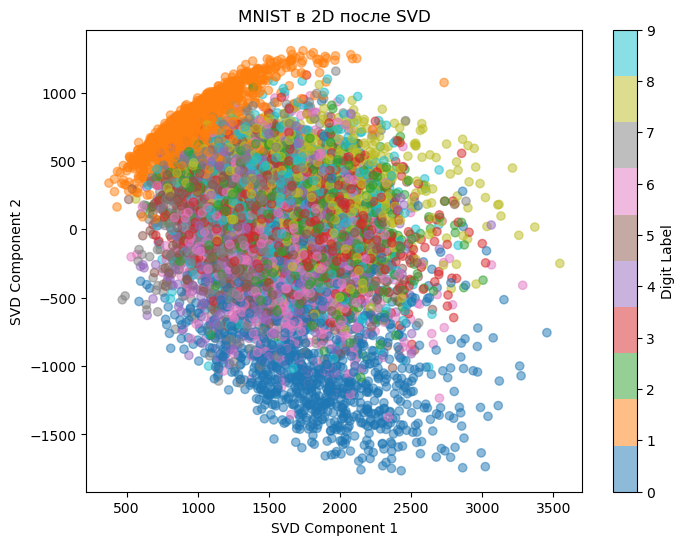

In [9]:
# Применяем SVD для уменьшения размерности c 784 до 2

svd = TruncatedSVD(n_components=2)
X_svd = svd.fit_transform(X_all_flat)  # Преобразуем 784 -> 2

# Визуализация результата
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_svd[:, 0], X_svd[:, 1], c=y_all, cmap="tab10", alpha=0.5)
plt.colorbar(scatter, label="Digit Label")
plt.xlabel("SVD Component 1")
plt.ylabel("SVD Component 2")
plt.title("MNIST в 2D после SVD")
plt.show()

### 3 TSNE

t-SNE — это алгоритм машинного обучения для визуализации многомерных данных, предложенный Лоренсом ван дер Маатеном и Джеффри Хинтоном в 2008 году.

### Краткий алгоритм метода TSNE

1) Строим таблицу n на n симметричную, где каждое значение таблицы это вероятность от 0 до 1 что эти точки соседи

2) Далее в нашей новой размерности, например, 2 мы случайно инициализируем точки и точно так же строим для них свою таблицу   

3) Минимизируя расхождение Кульбака-Лейблера между 1-ой и 2-ой таблицей градиентным спуском, подбираем точки из малой размерности так, чтобы вторая таблица больше походила на 1-ую

### Более детальный алгоритм метода TSNE, но не полностью "прокопал" алгоритм

1. **Построение распределения вероятностей в исходном пространстве**

Для каждой пары точек вычисляется вероятность, что они являются "соседями":

$$
p_{j|i} = \frac{\exp\left(-\|x_i - x_j\|^2 / 2\sigma_i^2\right)}{\sum_{k \neq i} \exp\left(-\|x_i - x_k\|^2 / 2\sigma_i^2\right)}
$$

где:

- $x_i, x_j$ — точки в исходном пространстве,  
- $\sigma_i$ — параметр, подобранный так, чтобы у каждой точки было "разумное" число соседей (определяется через перплексию).


**Перплексия (Perplexity)**  
Определяет число ближайших соседей, которые учитываются для каждой точки.

То есть это "настройка радиуса внимания" для каждой точки:

Типичные значения: от 5 до 50.

Малая перплексия → акцент на локальных структурах.

Большая перплексия → глобальная структура.

**Получаем**  
Матрица размером $n \times n$, где $n$ — количество точек в датасете.  

Все значения — от 0 до 1.

Каждая строка этой матрицы — это распределение вероятностей "быть соседом" для фиксированной точки $x_i$ среди остальных

**Затем симметризуем вероятности:**  

$$
p_{ij} = \frac{p_{j|i} + p_{i|j}}{2N}
$$

где $N$ — общее количество точек.

**Получаем симметричную матрицу**  

2. **Построение распределения в пространстве меньшей размерности**

Мы создаём новые точки $y_1, y_2, ..., y_n$ в 2D-пространстве  

Эти точки инициализируются случайно (обычно маленькими случайными значениями, например из нормального распределения со средним 0 и маленькой дисперсией)  

В новом пространстве (например, 2D), для точек $y_i$ и $y_j$ строится распределение, похожее на t-распределение Стьюдента (что помогает избежать "склеивания" точек из-за "проклятия размерности"):

$$
q_{ij} = \frac{(1 + \|y_i - y_j\|^2)^{-1}}{\sum_{k \ne l} (1 + \|y_k - y_l\|^2)^{-1}}
$$

3. **Минимизация расхождения между распределениями**

Алгоритм оптимизирует расположение точек $y_i$, минимизируя расхождение Кульбака-Лейблера между $p_{ij}$ и $q_{ij}$:

$$
KL(P \parallel Q) = \sum_{i \ne j} p_{ij} \log \frac{p_{ij}}{q_{ij}}
$$

Для оптимизации обычно используется **градиентный спуск**.

**Плюсы и минусы TSNE**  

**✔ Плюсы:**  
Отлично сохраняет локальные кластеры.

Хорошо работает для данных с нелинейной структурой.

Подходит для визуализации высокомерных данных (например, word embeddings, MNIST).

**✖ Минусы:**  
Результат зависит от параметров (перплексия, learning rate).

Медленный для больших датасетов (O(N²)).

Глобальная структура может искажаться (например, расстояния между кластерами не всегда информативны).

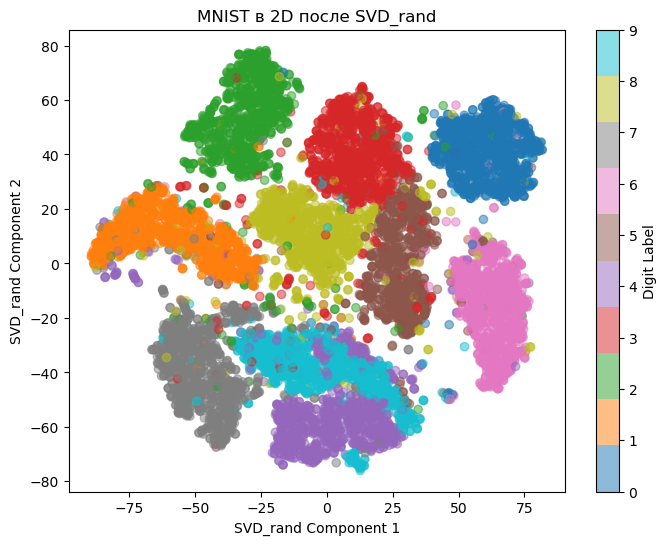

CPU times: total: 3min 57s
Wall time: 57.4 s


In [10]:
%%time 

tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_all_flat)  # Преобразуем 784 -> 2

# Визуализация результата
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_all, cmap="tab10", alpha=0.5)
plt.colorbar(scatter, label="Digit Label")
plt.xlabel("SVD_rand Component 1")
plt.ylabel("SVD_rand Component 2")
plt.title("MNIST в 2D после SVD_rand")
plt.show()

### 4 UMAP

### Алгоритм UMAP

1. **Строим граф соседей в исходном пространстве.**  
   Для каждой точки $x_i$ находим $k$ ближайших соседей (обычно 15–50), и рассчитываем взвешенные вероятности связей между точками.  
   Эти вероятности отражают, насколько точки "близки" друг к другу в высокоразмерном пространстве:

   $$
   p_{ij} = \exp\left(-\frac{\|x_i - x_j\| - \rho_i}{\sigma_i}\right)
   $$

   где $\rho_i$ — минимальное расстояние до любого соседа (чтобы сохранить локальную структуру),  
   а $\sigma_i$ — параметр, подбираемый так, чтобы обеспечить "равномерную плотность" соседей.

2. **Строим симметричный граф (аналог матрицы $P$):**  
   После вычисления вероятностей связей, UMAP симметризует их:
   
   $$
   P_{ij} = p_{ij} + p_{ji} - p_{ij} \cdot p_{ji}
   $$

   Это создает взвешенный граф, где веса соответствуют силе связи между точками.

3. **Случайная инициализация точек в низкоразмерном пространстве.**  
   Например, в 2D — получаем точки $y_1, y_2, \dots, y_n$.

4. **Оптимизация расположения точек в новом пространстве.**  
   Строится граф в 2D-пространстве с помощью "мягкой" логической функции:

   $$
   q_{ij} = \frac{1}{1 + a \cdot \|y_i - y_j\|^{2b}}
   $$

   где параметры $a$ и $b$ подобраны так, чтобы приближать распределение на основе t-распределения.

5. **Минимизируется кросс-энтропия между графами $P$ и $Q$.**  
   Оптимизация происходит методом стохастического градиентного спуска:

   - Увеличиваем притяжение между точками, которые были соседями в $P$.
   - Увеличиваем отталкивание между точками, которые не были связаны.

   Таким образом, сохраняется **локальная структура** данных при переходе к меньшей размерности.

C:\Users\Rinat\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\Rinat\AppData\Roaming\Python\Python311\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


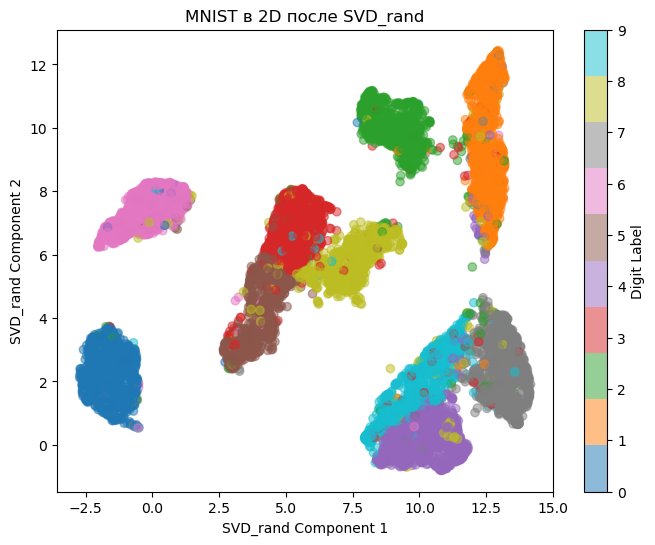

CPU times: total: 42.5 s
Wall time: 42.7 s


In [11]:
%%time

umap = umap.UMAP(n_components=2, random_state=42, n_jobs=-1)  # Использует все ядра для параллельности
X_umap = umap.fit_transform(X_all_flat)  # Преобразуем 784 -> 2

# Визуализация результата
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_umap[:, 0], X_umap[:, 1], c=y_all, cmap="tab10", alpha=0.5)
plt.colorbar(scatter, label="Digit Label")
plt.xlabel("SVD_rand Component 1")
plt.ylabel("SVD_rand Component 2")
plt.title("MNIST в 2D после SVD_rand")
plt.show()

### 5 LocallyLinearEmbedding

### Как работает алгоритм Locally Linear Embedding (LLE)?

1. **Нахождение ближайших соседей**:
   
   Для каждой точки в данных (объекта) мы находим ее $ k $-ближайших соседей. Это делается с помощью стандартных методов, таких как вычисление евклидовых расстояний между точками.

2. **Построение линейных коэффициентов**:
   
   Каждую точку представляют как линейную комбинацию ее ближайших соседей. Это делается таким образом, чтобы минимизировать ошибку реконструкции:
   
   $$
   x_i \approx \sum_{j \in N(i)} w_{ij} x_j
   $$
   
   где $ x_i $ — это точка $ i $, а $ x_j $ — соседи, $ w_{ij} $ — коэффициенты линейной комбинации. Эти коэффициенты $ w_{ij} $ можно найти путем решения оптимизационной задачи для каждой точки, минимизируя разницу между точкой и линейной комбинацией ее соседей.

3. **Минимизация потерь при проекции**:

   После того как для всех точек вычислены линейные коэффициенты, алгоритм пытается найти такое низкоразмерное представление точек (например, в 2D или 3D), которое сохраняет эти локальные линейные связи. То есть, для каждой точки $ i $ в новом пространстве должно выполняться следующее условие:
   
   $$
   y_i \approx \sum_{j \in N(i)} w_{ij} y_j
   $$
   
   где $ y_i $ — это новая проекция точки $ x_i $ в низкоразмерное пространство, а $ y_j $ — это новые проекции соседей. Оптимизация заключается в минимизации этой ошибки для всех точек, что приводит к сохранению локальной структуры данных.

4. **Поиск проекции с помощью собственных значений**:

   Для выполнения оптимизации используется метод, аналогичный задаче собственного разложения (eigenproblem). Для этого строится матрица графа на основе линейных коэффициентов $ w_{ij} $, и затем решается собственная задача для этой матрицы.

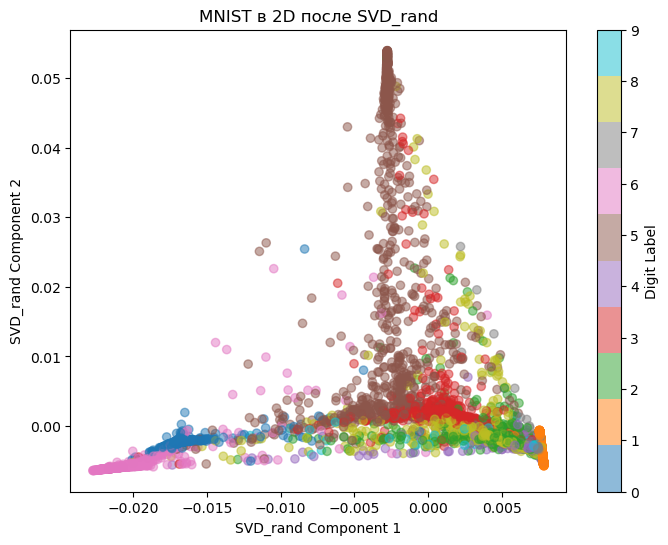

CPU times: total: 48.7 s
Wall time: 12.2 s


In [12]:
%%time
lle = LocallyLinearEmbedding(n_components=2, n_neighbors=5, tol=1e-06)
X_lle = lle.fit_transform(X_all_flat)  # Преобразуем 784 -> 2

# Визуализация результата
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_lle[:, 0], X_lle[:, 1], c=y_all, cmap="tab10", alpha=0.5)
plt.colorbar(scatter, label="Digit Label")
plt.xlabel("SVD_rand Component 1")
plt.ylabel("SVD_rand Component 2")
plt.title("MNIST в 2D после SVD_rand")
plt.show()

### 6 The quality of dimensionality reduction will be evaluated using our own metric

**Оценим качество понижения размерности своей метрикой**  

In [13]:
from scipy.spatial.distance import cdist
from sklearn.preprocessing import MinMaxScaler

Сначала все расстояния приводятся к значениям от 0 до 1 при помощи MinMaxScaler()  

Эта функция показывает 3 параметра:  
   
- среднее внутриклассовых расстояний
- среднее межклассовых расстояний
- таблицу внутриклассового расстояния для каждого класса

In [14]:
def compute_mean_distances(X, y):
    # Масштабируем каждую компоненту так, чтобы min=0, max=1
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)

    unique_classes = np.unique(y)
    intra_class_distances = []
    intra_class_table = []

    # Внутриклассовые расстояния
    for c in unique_classes:
        class_points = X_scaled[y == c]
        dist_matrix = cdist(class_points, class_points, metric='euclidean')
        np.fill_diagonal(dist_matrix, 0)  # Убираем расстояния самих точек до себя
        mean_distance = dist_matrix.mean() # средние дистанции для каждого класса 
        # (среднее значение значение квадратной матрицы расстояний, где каждый эл-т расстояние i-ой точки до j-ой)
        intra_class_distances.append(mean_distance) 
        intra_class_table.append((c, mean_distance))  # Запоминаем класс и расстояние

    # Создаём DataFrame для внутриклассовых расстояний
    intra_class_df = pd.DataFrame(intra_class_table, columns=["Class", "Intra-Class Distance"])

    # Межклассовые расстояния
    inter_class_distances = []
    for i, c1 in enumerate(unique_classes):
        for c2 in unique_classes[i+1:]:
            class1_points = X_scaled[y == c1]
            class2_points = X_scaled[y == c2]
            dist_matrix = cdist(class1_points, class2_points, metric='euclidean')
            inter_class_distances.append(dist_matrix.mean())

    return np.mean(intra_class_distances), np.mean(inter_class_distances), intra_class_df

In [15]:
### PCA
mean_intra, mean_inter, df_distances = compute_mean_distances(X_pca, y_all)

print(f"Среднее внутриклассовое расстояние: {mean_intra:.4f}")
print(f"Среднее межклассовое расстояние: {mean_inter:.4f}")
df_distances

Среднее внутриклассовое расстояние: 0.1872
Среднее межклассовое расстояние: 0.3250


,Class,Intra-Class Distance
0,0,0.201346
1,1,0.112358
2,2,0.217844
3,3,0.203615
4,4,0.180733
5,5,0.208856
6,6,0.198073
7,7,0.183263
8,8,0.181871
9,9,0.183586


In [16]:
methods = {
    'PCA': X_pca,
    'SVD': X_svd,
    't-SNE': X_tsne,
    'UMAP': X_umap,
    'LLE': X_lle
}

# Храним результаты
intra_tables = {}
inter_values = {}
mean_intra_values = {}

# Применяем функцию к каждой проекции
for name, X in methods.items():
    mean_intra, mean_inter, df_intra = compute_mean_distances(X, y_all)
    intra_tables[name] = df_intra.set_index("Class")["Intra-Class Distance"]
    inter_values[name] = mean_inter
    mean_intra_values[name] = mean_intra  # Сохраняем среднее внутриклассовое расстояние

# Объединяем в единую таблицу внутриклассовых расстояний
intra_df_all = pd.DataFrame(intra_tables)

# Таблица межклассовых расстояний
inter_df = pd.DataFrame.from_dict(inter_values, orient='index', columns=["Inter-Class Distance"]).T

# Таблица средних внутриклассовых расстояний
mean_intra_df = pd.DataFrame(mean_intra_values, index=["Mean Intra-Class Distance"])

# Вывод
print("Внутриклассовые расстояния:")
display(intra_df_all)

print("\nМежклассовые расстояния:")
display(inter_df)

print("\nСреднее внутриклассовое расстояние для каждого метода:")
display(mean_intra_df)

Внутриклассовые расстояния:


,PCA,SVD,t-SNE,UMAP,LLE
Class,,,,,
0,0.201346,0.244440,0.115919,0.087595,0.028548
1,0.112358,0.138790,0.144201,0.159400,0.034026
2,0.217844,0.212511,0.170059,0.135635,0.080902
3,0.203615,0.199272,0.152345,0.114035,0.091684
4,0.180733,0.210086,0.178845,0.141520,0.032049
5,0.208856,0.210204,0.143419,0.132941,0.423183
6,0.198073,0.229241,0.130003,0.102707,0.065475
7,0.183263,0.211032,0.148473,0.121679,0.011245
8,0.181871,0.210631,0.146207,0.140996,0.113079



Межклассовые расстояния:


,PCA,SVD,t-SNE,UMAP,LLE
Inter-Class Distance,0.324952,0.28447,0.467607,0.524953,0.420409



Среднее внутриклассовое расстояние для каждого метода:


,PCA,SVD,t-SNE,UMAP,LLE
Mean Intra-Class Distance,0.187154,0.208019,0.150383,0.127822,0.090803
